<a href="https://colab.research.google.com/github/JoshStrong/MAML/blob/master/MAML_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Please open in Colab, if viewing from GitHub.

In [ ]:
!pip install learn2learn

In [2]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

import copy

import learn2learn as l2l

In [3]:
# GPU assigned by google colab for training
torch.cuda.get_device_name(0)

'Tesla K80'

## Setting up classes to aid with sampling sinusoid tasks from a specific distribution

In [4]:
# The model architecture of the neural network
# we will use for training:
# 2 hidden layers of size 40, with ReLU non-linearities
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.fc1 = nn.Linear(1, 40)
    self.fc2 = nn.Linear(40, 40)
    self.fc3 = nn.Linear(40, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [5]:
# Sine_Task_Distribution is a class which determines the distributions from which
# tasks are sampled from.
class Sine_Task_Distribution():
  
  def __init__(self, power_min, power_max, amplitude_min, amplitude_max, phase_min, phase_max, xmin, xmax):
    self.power_min = power_min
    self.power_max = power_max
    self.amplitude_min = amplitude_min
    self.amplitude_max = amplitude_max
    self.phase_min = phase_min
    self.phase_max = phase_max
    self.xmin = xmin
    self.xmax = xmax

  def sample_task(self):
    """
    sample_task: randomly samples a task from a given distribution
    """
    amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
    power = np.random.randint(self.power_min,self.power_max+1)
    phase = np.random.uniform(self.phase_min, self.phase_max)

    return Sine_Task(power, amplitude, phase, self.xmin, self.xmax)

In [6]:
# Sine_Task is class from which we can use to generate training data from
class Sine_Task():
  def __init__(self, power, amplitude, phase, xmin, xmax):
    self.power = power
    self.phase = phase
    self.amplitude = amplitude
    self.xmin = xmin
    self.xmax = xmax

  def oracle(self, x):
    """
    Oracle: returns output of sin function with given amplitude, phase and input x

    PARAMETERS:
    1. x - input
    """
    return self.amplitude * (x **self.power) * np.sin(self.phase + x)

  def sample_data(self, size=1):
    """
      sample_data: sample input/output of given instance of Sine_Task with set variables

      PARAMETERS:
      1. size - amount of sampled data (1 default)
    """
    x = torch.rand(size)*(self.xmax-self.xmin) - self.xmax
    y = self.oracle(x)
    x = x.unsqueeze(1).cuda()
    y = y.unsqueeze(1).cuda()

    return x, y

In [7]:
# Generate the desired distribution from which tasks
# will be sampled from:
# args =  (power_min, power_max, amplitude_min, amplitude_max, phase_min, phase_max, xmin, xmax)
dist = Sine_Task_Distribution(0,1,0.1,5,0,np.pi,-5,5)

## Implementing MAML

The (shortened) MAML algorithm:




*   Sample task (or a batch of tasks) $\mathcal{T}_i$.
*   Sample $D_i^{tr}, D_i^{test}$ from sampled task $\mathcal{T}_i$.
*   Inner Loop: Optimise meta-parameters $\theta$ on task $\mathcal{T}_i$ to produce task-specific optimal parameters $\phi_i$: $\phi_i \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D_i^{tr})$
*   Outer Loop: Update $\theta$ using stochastic gradient descent:
$\theta \leftarrow \theta - \beta \nabla_\theta \mathcal{L}(\phi, D_i^{test})$

where $\mathcal{L}(\cdot, \cdot)$ is the chosen loss function of the network (MSE for regression & binary cross entropy for classification).



Let $U(\theta, D^{tr}) := \phi = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D^{tr})$ denote the update rule used for optimising $\phi$.



The meta-optimisation objective is given as 
\begin{align*}
    \underset{\theta}{\min}\,\,\mathcal{L}(\phi, D^{test}) = \underset{\theta}{\min}\,\,\mathcal{L}(U(\theta, D^{tr}), D^{test}).
\end{align*}
We require $\frac{d}{d\theta}\mathcal{L}(\phi, D^{test})$
\begin{align*}
    \frac{d}{d\theta}\mathcal{L}(\phi, D^{test}) &= \frac{d}{d\theta}\mathcal{L}(U(\theta, D^{tr}), D^{test})\\
    &= \underbrace{\nabla_{\Theta}\mathcal{L}(\Theta, D^{test})|_{\Theta=U(\theta, D^{tr})}}_{(1)} \underbrace{\dfrac{d}{d \theta} U(\theta, D^{tr})}_{(2)} && (\text{via chain rule})
\end{align*}

(1) is a row vector which can be computed through a single backwards pass of the network, when setting parameters to $\Theta$ then differentiating loss $\mathcal{L}$ with respects to $\Theta$. The hessian matrix (2) is obtained through differentiating the update rule $U(\theta, D^{tr}) = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, D^{tr})$ with respects to $\theta$. Fortunately for us, autodiff libraries such as Tensorflow and PyTorch can compute vector hessian products efficiently.


Below, I make use of the meta-learning library learn2learn [1], a software library for meta-learning research, for performing the meta-update.


[1] Sebastien M.R. Arnold, Praateek Mahajan, Debajyoti Datta, Ian Bunner. "learn2learn". https://github.com/learnables/learn2learn, 2019

In [8]:
def MAML(num_iterations, first_order, model, device, inner_lr, meta_lr, meta_batch_size, K, adaptation_steps):
  model.to(device)
  maml = l2l.algorithms.MAML(model, lr=inner_lr, first_order=first_order)
  opt = torch.optim.Adam(maml.parameters(), meta_lr)
  loss = nn.MSELoss(reduction='mean')
  best_valid_err = 1000

  # Meta-learning
  # Outer-loop
  for iteration in tqdm(range(num_iterations+1)):
    opt.zero_grad()
    meta_valid_error = 0.0
    for task in range(meta_batch_size):
      # Make copy of maml class
      learner = maml.clone()

      # Sample a batch of training data D^{tr}
      task = dist.sample_task()
      X_train, y_train = task.sample_data(K)

      # Inner-loop
      for step in range(adaptation_steps):
        train_error = loss(learner(X_train), y_train)
        learner.adapt(train_error)

      # Sample new data D^{test}, calculate error
      X_valid, y_valid = task.sample_data(K)
      valid_error = loss(learner(X_valid),y_valid)

      # Backpropagate loss wrt meta-parameters to get parameter gradients
      # These accumulate by function, so no need to continuously add
      # We opt.zero_grad at each iteration instead
      valid_error.backward()

      # add evaluation_error
      meta_valid_error += valid_error.item()

    avg_meta_valid_err = meta_valid_error/meta_batch_size
    if avg_meta_valid_err < best_valid_err:
      best_valid_err = avg_meta_valid_err
      best_model = copy.deepcopy(model)
    
    if iteration % 50 == 0:
      print('\n')
      print('Iteration', iteration)
      print('Average Meta Valid Error', avg_meta_valid_err)

    # Average the accumulated gradients from all tasks and optimize
    for p in maml.parameters():
      p.grad.data.mul_(1.0 / meta_batch_size)
    opt.step() # optimise meta-parameters

  return best_model

In [ ]:
## WARNING: Running this cell trains MAML algorithm
##          which takes a long time to train (~11 hrs w/ Tesla T4 GPU).
##          Instead of training, please ask for pre-trained model parameters.

device = torch.device('cuda')
inner_lr = 0.01
meta_lr = 0.01
meta_batch_size = 1000
K = 10
adaptation_steps = 1


## First train the model with 2500 iterations of FOMAML
## Save the model parameters, then train with 2500 iterations of MAML

model = Model()
fomaml_model = MAML(2500, True, model, device, inner_lr, meta_lr, meta_batch_size, K, adaptation_steps)
maml_model = MAML(2500, False, fomaml_model, device, inner_lr, meta_lr, meta_batch_size, K, adaptation_steps)

In [ ]:
# Save the meta-parameters to a file
# Need to clip 'module.' from parameter keys in order to reload the model first
maml_dict = maml_model.state_dict()
prefix = 'module.'
n_clip = len(prefix)
adapted_dict = {k[n_clip:]: v for k, v in maml_dict.items()
                if k.startswith(prefix)}

PATH = "/content/model"
torch.save(adapted_dict, PATH)

In [17]:
# Load MAML saved parameters
PATH = "/content/model"
saved_model = Model()
saved_model.load_state_dict(torch.load(PATH), strict=False)
saved_model.to('cuda')

Model(
  (fc1): Linear(in_features=1, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=1, bias=True)
)

## Fine-tuning and model comparison

In [184]:
# Generate tasks with powers 0 and 1
seed=2135
np.random.seed(seed)

testing_task1=dist.sample_task()
testing_task2=dist.sample_task()
print("testing_task1 has power",testing_task1.power)
print("testing_task2 has power",testing_task2.power)

# Make copies of the MAML model
fine_tuned_model1 = copy.deepcopy(saved_model)
fine_tuned_model2 = copy.deepcopy(saved_model)

testing_task1 has power 0
testing_task2 has power 1


Sampled task 1 has amplitude: 4.361402999903732 and phase: 1.65494869953533
Sampled task 2 has amplitude: 4.267303782195782 and phase: 2.479856787941293


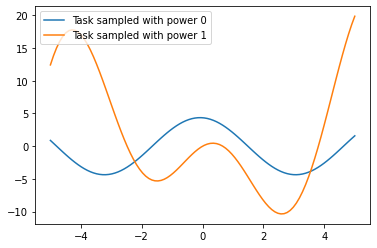

In [185]:
print("Sampled task 1 has amplitude:",testing_task1.amplitude,"and phase:", testing_task1.phase)
print("Sampled task 2 has amplitude:",testing_task2.amplitude,"and phase:", testing_task2.phase)

x = torch.linspace(-5,5).cuda()
output = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Task sampled with power 0")
plt.plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Task sampled with power 1")

plt.legend(loc="upper left")
plt.show()

In [186]:
## Fine-tuning task 1

x_train_task1,y_train_task1 = testing_task1.sample_data(10)

fine_tuning_steps=10
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fine_tuned_model1.parameters(),lr=0.02)

for step in range(fine_tuning_steps):
  y_pred = fine_tuned_model1(x_train_task1)

  loss = criterion(y_pred,y_train_task1)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

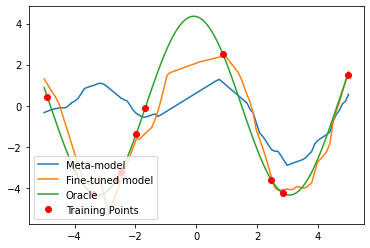

In [187]:
# Visualise results of task 1 fine-tuning

output_task1 = [fine_tuned_model1(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
plt.plot(x.cpu(),output_task1,label="Fine-tuned model")
plt.plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Oracle")

plt.plot(x_train_task1.cpu(),y_train_task1.cpu(),'ro',label="Training Points")

plt.legend(loc="lower left")
plt.show()

In [188]:
## Fine-tuning task 2

x_train_task2,y_train_task2 = testing_task2.sample_data(10)

fine_tuning_steps=10
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fine_tuned_model2.parameters(),lr=0.02)

for step in range(fine_tuning_steps):
  y_pred = fine_tuned_model2(x_train_task2)

  loss = criterion(y_pred,y_train_task2)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

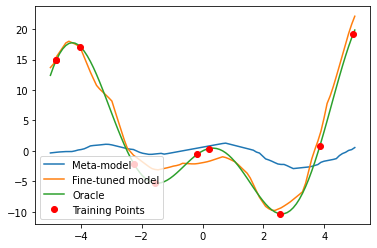

In [189]:
# Visualise results of task 2 fine-tuning

output_task2 = [fine_tuned_model2(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output,label="Meta-model")
plt.plot(x.cpu(),output_task2,label="Fine-tuned model")
plt.plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Oracle")

plt.plot(x_train_task2.cpu(),y_train_task2.cpu(),'ro',label="Training Points")

plt.legend(loc="lower left")
plt.show()

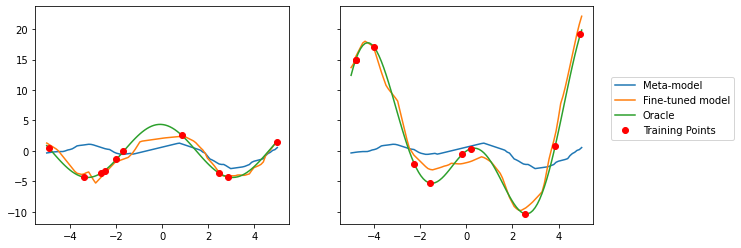

In [190]:
# More visualisations

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)

loc = "upper right"

#axes[0].plot(x.cpu(),output,label="Meta-model")
#axes[0].plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Task sampled with power 0")
#axes[0].plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Task sampled with power 1")
#axes[0].legend(loc=loc)

axes[0].plot(x.cpu(),output,label="Meta-model")
axes[0].plot(x.cpu(),output_task1,label="Fine-tuned model")
axes[0].plot(x.cpu(),testing_task1.oracle(x.cpu()),label="Oracle")
axes[0].plot(x_train_task1.cpu(),y_train_task1.cpu(),'ro',label="Training Points")
#axes[0].legend(loc=loc)

axes[1].plot(x.cpu(),output,label="Meta-model")
axes[1].plot(x.cpu(),output_task2,label="Fine-tuned model")
axes[1].plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Oracle")
axes[1].plot(x_train_task2.cpu(),y_train_task2.cpu(),'ro',label="Training Points")
axes[1].legend(bbox_to_anchor=(1.05, 0.7), loc='upper left')


plt.show()

## Comparison with pre-trained model

In [ ]:
# Train 500 models on 500 tasks, with large amount of data
# Take multi-task parameters as average of parameter vectors

num_models = 500
criterion = nn.MSELoss(reduction='mean')
learning_rate = 0.02
num_grad_iter = 100

# Generates 500 instances of Models class with an associated task
Models = [(Model().to('cuda'), dist.sample_task()) for x in range(num_models)]

for model, task in tqdm(Models):

  # Sample 100 data
  x_train, y_train = task.sample_data(100)
  # Initialise Adam optimiser
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

  for _ in range(num_grad_iter):
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# Average the parameters
model = Model().to('cuda')
avgModel = model.state_dict()

for key in avgModel:
  avgModel[key] -= avgModel[key]

for model, task in Models:
  for key in avgModel:
    tempSD = model.state_dict()
    avgModel[key] += tempSD[key]

for key in avgModel:
  avgModel[key] /= num_models

In [ ]:
pre_trained_model = Model().to('cuda')
model.load_state_dict(avgModel)

<All keys matched successfully>

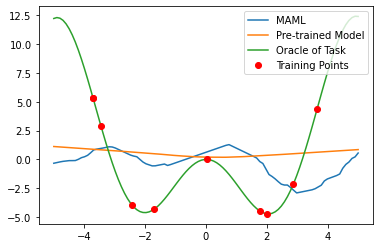

In [ ]:
# Visualise pre-trained model, MAML parameters
# and task 2 oracle
output_pre_trained = [pre_trained_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]
output_MAML = [saved_model(item.unsqueeze(-1)).cpu().detach().numpy() for item in x]

plt.plot(x.cpu(),output_MAML,label="MAML")
plt.plot(x.cpu(),output_pre_trained,label="Pre-trained Model")
plt.plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Oracle of Task")
plt.plot(x_train_task2.cpu(),y_train_task2.cpu(),'ro',label="Training Points")

plt.legend(loc="upper right")
plt.show()

In [ ]:
# Fine-tune the model, under same conditions in MAML
# using same data

fine_tuned_pretrained = copy.deepcopy(pre_trained_model)
fine_tuning_steps=10
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(fine_tuned_pretrained.parameters(),lr=0.1)

for step in range(fine_tuning_steps):
  y_pred = fine_tuned_pretrained(x_train_task2)

  loss = criterion(y_pred,y_train_task2)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

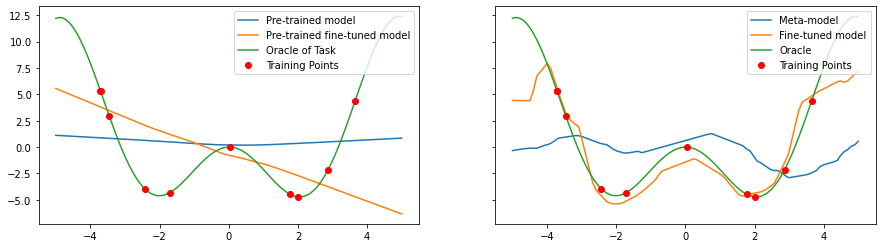

In [ ]:
# Visualise MAML v.s. pre-trained model

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharex=True, sharey=True)

loc = "upper right"

axes[0].plot(x.cpu(),output_pre_trained,label="Pre-trained model")
axes[0].plot(x.cpu(),output_fine_tuned_pretrained,label="Pre-trained fine-tuned model")
axes[0].plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Oracle of Task")
axes[0].plot(x_train_task2.cpu(),y_train_task2.cpu(),'ro',label="Training Points")
axes[0].legend(loc=loc)

axes[1].plot(x.cpu(),output,label="Meta-model")
axes[1].plot(x.cpu(),output_task2,label="Fine-tuned model")
axes[1].plot(x.cpu(),testing_task2.oracle(x.cpu()),label="Oracle")
axes[1].plot(x_train_task2.cpu(),y_train_task2.cpu(),'ro',label="Training Points")
axes[1].legend(loc=loc)

plt.show()